In [1]:
import pandas as pd
import os
os.chdir('..')
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from xgboost import XGBRegressor
from utils import *

import wandb
from wandb.xgboost import WandbCallback
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

In [17]:
df_first = pd.read_csv(r'data\cleaned_data\5_household\power\SFH4_demand_W.csv', index_col=0, parse_dates=True)

#df_first = pd.read_csv(r"C:\Users\nik\iCloudDrive\PhD_Icloud\PhD_Papers\Berkeley\Data\load_data_15min_watts.csv", index_col=0, parse_dates=True).iloc[:,-1:]


### Benchmarks

In [3]:
# create the persistence benchmarks
gt_long = df_first.loc[test_idx]
benchmark_day = gt_long.shift(n_timesteps_per_day).fillna(0).values.flatten() # previous day
benchmark_week = gt_long.shift(n_timesteps_per_day*7).fillna(0).values.flatten() # same day of previous week
gt = gt_long.values.flatten()


NameError: name 'test_idx' is not defined

### Visualization for the resolution

In [10]:
df_compare = pd.DataFrame({'gt':gt, 
                            'predictions': predictions_reshaped,
                            'benchmark_day': benchmark_day,
                            'benchmark_week': benchmark_week}, index=test_idx
                            )[96*7:]

px.line(df_compare,  title='XGBoost Regression')

In [11]:
df_metrics = calc_metrics(df_compare, [mean_squared_error, mean_absolute_error])
df_metrics


,root_mean_squared_error,mean_absolute_error
predictions,497.475564,429.802471
benchmark_day,506.427590,247.057697
benchmark_week,510.731431,255.487735


### Visualization For Daily Energy

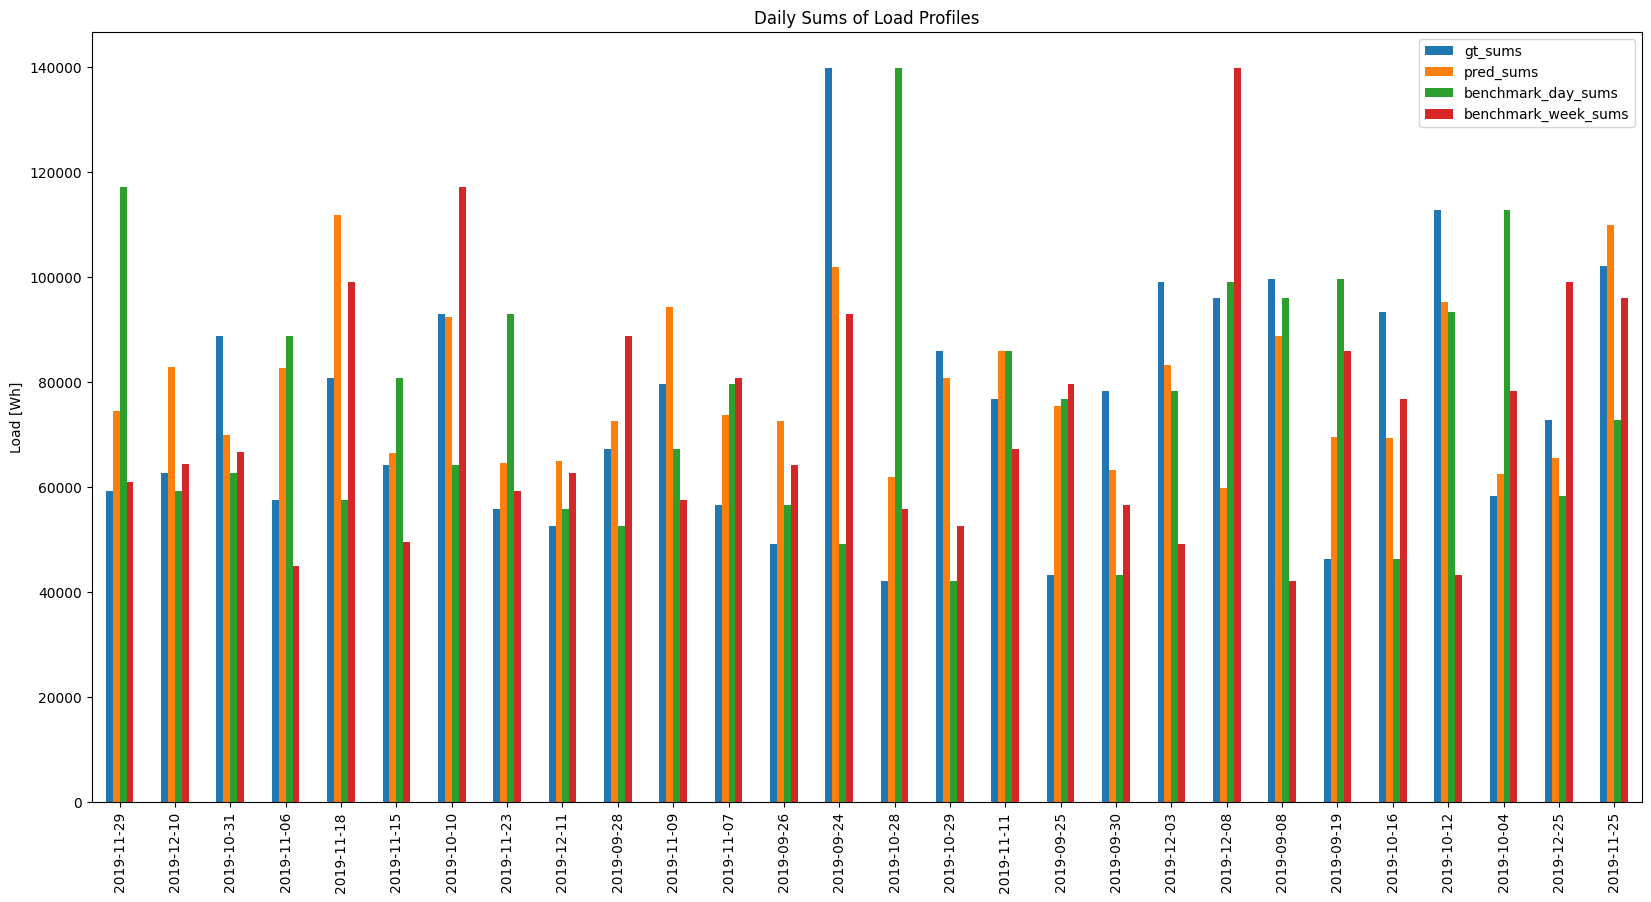

In [32]:

start_later = 7
benchmark_day_per_day = benchmark_day.reshape(predictions.shape)[start_later:]
benchmark_week_per_day = benchmark_week.reshape(predictions.shape)[start_later:]
predictions_per_day = predictions_reshaped.reshape(predictions.shape)[start_later:].sum(axis=1)
gt_per_day = gt.reshape(predictions.shape)[start_later:].sum(axis=1)

df_daily_sum = pd.DataFrame({ 
                            'gt_sums':gt_per_day,
                            'pred_sums': predictions_per_day,
                            'benchmark_day_sums': benchmark_day_per_day.sum(axis=1),
                            'benchmark_week_sums': benchmark_week_per_day.sum(axis=1)
                             }, index=list(set(test_idx.date))[start_later:]
                             )[:28] * 4

df_daily_sum.plot(title='Daily Sums of Load Profiles', kind='bar', figsize=(20,10))
plt.ylabel('Load [Wh]')
plt.show()

In [33]:
df_metrics_daily = calc_metrics(df_daily_sum, [mean_squared_error,mean_absolute_error])
df_metrics_daily

,root_mean_squared_error,mean_absolute_error
pred_sums,19219.049828,16457.450106
benchmark_day_sums,38297.690041,30030.123138
benchmark_week_sums,29622.851585,24366.531484


## Wandb

### Testing

In [18]:
config_features = {
    'holidays': True,
    'peaks': True,
    'boxcox': False,
    'lam': None,
    'cumsum': False,
    'lagged_days': 0,
    'datetime': True,
    }


model_params = { 'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor',
    'objective': 'reg:pseudohubererror',
    #'eval_metric': dtw_scorer,
    'colsample_bytree': 1.0,
    'learning_rate': 0.3, 
    'max_depth': 12,
    'n_estimators': 800, 
    'subsample': 0.5,
    'reg_alpha': 0, 
    'reg_lambda': 0.05, 
    'gamma': 0.1,
    }


#plotting parameters
rows_to_plot = 4 # min 1
outputs_per_row = 4

In [20]:
def train():
    wandb.init(
        project="XGBoost",
        )

    wandb.config.update(config_features)
    wandb.config.update(model_params)

    config = wandb.config

    # Data cleaning
    #-----------------------#
    df = remove_duplicate_index(df_first)

    df = remove_days(df)

    df[df<=0] = 1e-6 # because of log transform

    #-----------------------#

    # Feature Engineering
    #-----------------------#
    if config.boxcox:
        df, config.lam = boxcox_transform(df)

    # scaling the data

    scaler = MinMaxScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])


    # long to wide format, because we are doing daily predictions
    df_pivot = timeseries_dataframe_pivot(df).dropna()
    n_timesteps_per_output = df_pivot.shape[1]

    # peaks
    if config.peaks:
        df_peak_feature = timeseries_peak_feature_extractor(df)
        df_peak_feature_shifted = df_peak_feature.shift(1)
        df_pivot = pd.concat([df_pivot, df_peak_feature_shifted], axis=1).dropna()
        df_pivot.index = pd.to_datetime(df_pivot.index)


    # past information
    if config.cumsum:
        df = calc_rolling_sum_of_load(df, 7)
        df["load_of_last_day"] = df.iloc[:,:n_timesteps_per_output].sum(axis=1).shift(1)

    lagged_days = config.lagged_days
    if config.lagged_days > 0:
        for i in range(2,lagged_days+1):
            df = pd.concat([df_pivot, df_pivot.iloc[:,:n_timesteps_per_output].shift(i)],axis=1).dropna()

    # holidays
    if config.holidays:
        years = get_year_list(df_pivot)
        df_holidays_dummies = get_holidays(years, "US")
        df_holidays = create_holiday_features(df_pivot, df_holidays_dummies)
        df_pivot = pd.concat([df_pivot, df_holidays], axis=1)

    # datetime features
    if config.datetime:
        df_pivot = create_datetime_features(df_pivot)

    df_final = df_pivot.astype('float32').iloc[1:-1,:] # last row is nan

    #-----------------------#

    # Splits 

    #-----------------------#
    test_size = 0.2
    train, test = train_test_split(df_final, test_size=test_size, shuffle=False)
    test_idx = unpivot_timeseries_dataframe(test.iloc[:, :n_timesteps_per_output]).index

    train = train
    test = test

    #features and target
    X_train = train.iloc[:,n_timesteps_per_output:]
    y_train = train.iloc[:,:n_timesteps_per_output]

    X_test = test.iloc[:,n_timesteps_per_output:]
    y_test = test.iloc[:,:n_timesteps_per_output]


    scaler_features = MinMaxScaler()
    X_train[X_train.columns] = scaler_features.fit_transform(X_train[X_train.columns])
    X_test[X_test.columns] = scaler_features.transform(X_test[X_test.columns])

    #-----------------------#

    # fit the model and make predictions

    #-----------------------#

    model = XGBRegressor(**model_params)

    model.learning_rate = config.learning_rate
    model.max_depth = config.max_depth
    model.n_estimators = config.n_estimators
    model.reg_alpha = config.reg_alpha
    model.reg_lambda = config.reg_lambda
    model.gamma = config.gamma

    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

    predictions = model.predict(X_test)
    predictions_reshaped = post_process_xgb_predictions(predictions, config.boxcox, scaler, config.lam)
    gt = df_first.loc[test_idx].values.flatten()

    eval_score = min(model.evals_result()['validation_0']['mae'])
    wandb.log({"mae": eval_score})


    #-----------------------#

    # Preparing the data for plotting and metrics

    # -----------------------#

    # per timestep
    df_compare = pd.DataFrame({'gt':gt,
                            'per_timestep': predictions_reshaped}, 
                            index=test_idx
                            )
    
    val_score = dtw_metric(df_compare['gt'], df_compare['per_timestep'])
    wandb.log({"dtw": val_score})

    # per day
    predictions_per_day = predictions_reshaped.reshape(predictions.shape).sum(axis=1)
    gt_per_day = gt.reshape(predictions.shape).sum(axis=1)
    df_daily_sum = pd.DataFrame({ 
                                'gt_sums':gt_per_day,
                                'per_day': predictions_per_day
                                }, index=list(set(test_idx.date))
                                )

    # -----------------------#

    # Calculate Metrics and log them

    # -----------------------#
    df_metrics_timestep = calc_metrics(df_compare, [mean_squared_error,mean_absolute_error])
    # calculate metrics per day
    df_metrics_daily = calc_metrics(df_daily_sum, [mean_squared_error,mean_absolute_error])

    table_timestep = wandb.Table(dataframe=df_metrics_timestep.reset_index())
    table_daily = wandb.Table(dataframe=df_metrics_daily.reset_index())

    wandb.log({"metrics_per_timestep": table_timestep})
    wandb.log({"metrics_per_day": table_daily})


    # -----------------------#

    # Plotting and logging

    # -----------------------#
    fig, ax = plt.subplots(rows_to_plot,1 , figsize=(40,20))
    for i in range(rows_to_plot):
        start = int(i*outputs_per_row*n_timesteps_per_output)
        end = int(start + outputs_per_row*n_timesteps_per_output)
        ax[i].plot(df_compare['gt'][start:end], label='gt')
        ax[i].plot(df_compare['per_timestep'][start:end], label='predictions')
    wandb.log({"Side-by-Side": wandb.Image(fig)})

    fig_daily = df_daily_sum.plot(title='Daily Sums of Load Profiles', kind='bar', figsize=(20,10))

    wandb.log({"Daily Sums": wandb.Image(fig_daily)})

    # -----------------------#
    wandb.finish()





In [ ]:
train()

### Execution

In [21]:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
        'name': 'mae',
        'goal': 'minimize'
    },
    'parameters': {
        'learning_rate': {
            'values': [0.01, 0.1, 0.5]
        },
        'reg_lambda': {
            'values': [0, 0.1, 0.5, 1]
        },
        'reg_alpha': {
            'values': [0, 0.1, 0.5, 1]
        },
        'n_estimators': {
            'values': [50, 100, 500, 1000]
        },
        'gamma': {
            'values': [0, 0.1, 0.5, 1]
        },
        'max_depth': {
            'values': [3, 6, 10, 12, 15]
        },
        'lagged_days': {
            'values': [0, 1, 2, 3, 4, 5, 6, 7]
        }
}
}

In [22]:
sweep_id = wandb.sweep(sweep_config, project="XGBoost")
wandb.agent(sweep_id, train)


Create sweep with ID: uuup5q3e
Sweep URL: https://wandb.ai/wattcast/XGBoost/sweeps/uuup5q3e


wandb: Agent Starting Run: 63dsy6pp with config:
wandb: 	gamma: 0.1
wandb: 	lagged_days: 6
wandb: 	learning_rate: 0.01
wandb: 	max_depth: 6
wandb: 	n_estimators: 50
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Config item 'lagged_days' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_depth' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'n_estimators' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'reg_alpha' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'reg_lambda' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gamma' was locked by 'sweep' (ignored update).
c:\Users\nik\miniconda3\envs\gpu2\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
C:\Users\nik\AppData\Local\Temp\ipyke

: 

: 